In [1]:
import sys
import os
import random
import argparse
import datetime
import json
import numpy as np
import math
import tensorflow as tf
from gensim.models import Word2Vec
from pattern.text.en import tokenize
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from util_cnn import generate_synthetic_columns, synthetic_columns2sequence, sequence2matrix

current_path = os.getcwd()
parser = argparse.ArgumentParser()

parser.add_argument(
    '--model_dir',
    type=str,
    default='../../enwiki_model/',
    help='Directory of word2vec model'
)
parser.add_argument(
    '--output_dir',
    type=str,
    default=os.path.join(current_path, 'output/'),
    help='Directory of output'
)
parser.add_argument(
    '--cnn_dir',
    type=str,
    default=os.path.join(current_path, 'output/cnn'),
    help='Directory of trained models'
)
parser.add_argument(
    '--sample_file',
    type=str,
    default=os.path.join('sample_classes.json'),
    help='File containing pos, neg and general pos samples'
)
parser.add_argument(
    '--gap',
    type=float,
    default=1,
    help='The knowledge gap (percentage of particular entities used for training)'
)
parser.add_argument(
    '--train_type',
    type=int,
    default=2,
    help='0: Train CNN without fine tuning, using particular samples;'
         '1: Train CNN without fine tuning, using general samples;'
         '2: Train CNN without fine tuning, using general + particular samples'
         '3: Train CNN with fine tuning, training with particular samples, fine-tuning with general samples'
)
parser.add_argument(
    '--synthetic_column_size',
    type=int,
    default=1,
    help='Size of synthetic column'
)
parser.add_argument(
    '--sequence_size',
    type=int,
    default=15,
    help='Length of word sequence of synthetic column'
)
parser.add_argument(
    '--num_epochs',
    type=int,
    default=10,
    help='number of epochs'
)
parser.add_argument(
    '--dropout_keep_prob',
    type=float,
    default=0.5,
    help='dropout_keep_prob'
)
parser.add_argument(
    '--batch_size',
    type=int,
    default=32,
    help='batch size'
)
parser.add_argument(
    '--checkpoint_every',
    type=int,
    default=500,
    help='Save model after this many steps'
)
parser.add_argument(
    '--evaluate_every',
    type=int,
    default=500,
    help='Evaluate model on dev set after this many steps'
)
parser.add_argument(
    '--dev_sample_percentage',
    type=float,
    default=0.2,
    help='percentage of samples for development'
)
FLAGS, unparsed = parser.parse_known_args()

if not os.path.exists(FLAGS.cnn_dir):
    os.mkdir(FLAGS.cnn_dir)
cnn_dir = os.path.join(FLAGS.cnn_dir, 'cnn_%d_%d_%.2f' % (
    FLAGS.synthetic_column_size, FLAGS.train_type, FLAGS.gap))
if not os.path.exists(cnn_dir):
    os.mkdir(cnn_dir)


def load_json(data_json):
    with open(data_json) as json_file:
        return json.load(json_file)


samples = load_json(FLAGS.output_dir+FLAGS.sample_file)

if FLAGS.train_type == 0:
    print('Train CNN without fine tuning, using particular samples')
elif FLAGS.train_type == 1:
    print('Train CNN without fine tuning, using general samples')
elif FLAGS.train_type == 2:
    print('Train CNN without fine tuning, using general + particular samples')
elif FLAGS.train_type == 3:
    print('Train CNN with fine tuning, training with particular samples, fine-tuning with general samples')
else:
    sys.exit(0)


Train CNN without fine tuning, using general + particular samples


In [2]:
w2v_model = Word2Vec.load(os.path.join(FLAGS.model_dir, 'word2vec_gensim'))


In [3]:
def align_samples(pos, neg):
    if len(pos) <= len(neg):
        pos_new = pos * int(len(neg) / len(pos))
        neg_new = neg * 1
        pos_new += random.sample(pos, len(neg_new) - len(pos_new))
    else:
        neg_new = neg * (len(pos) / len(neg))
        pos_new = pos * 1
        neg_new += random.sample(neg, len(pos_new) - len(neg_new))
    return pos_new, neg_new

def embedding(entities_positive, entities_negative):
    # embedding
    units_positive = generate_synthetic_columns(
        entities_positive, FLAGS.synthetic_column_size)
    units_negative = generate_synthetic_columns(
        entities_negative, FLAGS.synthetic_column_size)

    sequences_positive = list()
    for ent_unit in units_positive:
        sequences_positive.append(
            synthetic_columns2sequence(ent_unit, FLAGS.sequence_size))
    sequences_negative = list()
    for ent_unit in units_negative:
        sequences_negative.append(
            synthetic_columns2sequence(ent_unit, FLAGS.sequence_size))

    x = np.zeros((len(sequences_positive) + len(sequences_negative),
                 FLAGS.sequence_size, w2v_model.vector_size, 1))
    for sample_i, sequence in enumerate(sequences_positive + sequences_negative):
        x[sample_i] = sequence2matrix(sequence, FLAGS.sequence_size, w2v_model)

    y_positive = np.ones((len(sequences_positive), 1))
    y_negative = np.zeros((len(sequences_negative), 1))
    y = np.concatenate((y_positive, y_negative))

    # shuffling
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(y.shape[0]))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    return x_shuffled, y_shuffled



In [4]:
for candidate_class in samples:
    cls_pos_par_entities = list(
        samples[candidate_class]['positive_samples'])
    cls_neg_par_entities = list(
        samples[candidate_class]['negative_samples'])
    cls_pos_gen_entities = list(
        samples[candidate_class]['general_pos_samples'])

    if len(cls_neg_par_entities) > 10000:
        cls_neg_par_entities = random.sample(cls_neg_par_entities, 1000)
        try:
            cls_pos_gen_entities = random.sample(
                cls_pos_gen_entities, 10000)
        except:
            pass

    if len(cls_pos_gen_entities) == 0 or len(cls_neg_par_entities) == 0 :
        continue

    entities_neg = cls_neg_par_entities
    p_ents, n_ents = align_samples(cls_pos_gen_entities, entities_neg)
    X, Y = embedding(p_ents, n_ents)
    p_ents_ft, n_ents_ft = align_samples(
        cls_pos_par_entities, entities_neg)
    X_ft, Y_ft = embedding(p_ents_ft, n_ents_ft)

    dev_sample_index = int(
        FLAGS.dev_sample_percentage * float(X_ft.shape[0]))
    X_train, X_dev = X_ft[dev_sample_index:], X_ft[:dev_sample_index]
    Y_train, Y_dev = Y_ft[dev_sample_index:], Y_ft[:dev_sample_index]
    print('     [particular samples] train size: %d, dev size: %d' %
          (X_train.shape[0], X_dev.shape[0]))


    input_shape = (FLAGS.sequence_size, w2v_model.vector_size, 1)

    # Build the model
    model = tf.keras.Sequential([
        Conv2D(32, 3, padding='same',
            activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(FLAGS.dropout_keep_prob),
        Dense(1, activation='sigmoid')
    ])

    # model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                    metrics=['accuracy'])

    # Fit the model
    history = model.fit(X_train, Y_train,
                        batch_size=FLAGS.batch_size,
                        epochs=FLAGS.num_epochs,
                        verbose=2)
    # save the model
    model.save(cnn_dir+'/%s' % candidate_class)
    tf.keras.backend.clear_session()
    clear_output(wait=True)


     [particular samples] train size: 4, dev size: 0
Epoch 1/10
1/1 - 2s - loss: 0.7021 - accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 2/10
1/1 - 0s - loss: 0.5573 - accuracy: 0.7500 - 82ms/epoch - 82ms/step
Epoch 3/10
1/1 - 0s - loss: 0.7161 - accuracy: 0.2500 - 88ms/epoch - 88ms/step
Epoch 4/10
1/1 - 0s - loss: 0.4719 - accuracy: 0.7500 - 78ms/epoch - 78ms/step
Epoch 5/10
1/1 - 0s - loss: 0.3863 - accuracy: 1.0000 - 96ms/epoch - 96ms/step
Epoch 6/10
1/1 - 0s - loss: 0.3494 - accuracy: 1.0000 - 109ms/epoch - 109ms/step
Epoch 7/10
1/1 - 0s - loss: 0.3895 - accuracy: 1.0000 - 112ms/epoch - 112ms/step
Epoch 8/10
1/1 - 0s - loss: 0.3146 - accuracy: 1.0000 - 93ms/epoch - 93ms/step
Epoch 9/10
1/1 - 0s - loss: 0.2526 - accuracy: 1.0000 - 105ms/epoch - 105ms/step
Epoch 10/10
1/1 - 0s - loss: 0.2323 - accuracy: 1.0000 - 110ms/epoch - 110ms/step
INFO:tensorflow:Assets written to: c:\Users\pinto\OneDrive - City, University of London\Project\ColNetNew\ColNet 2.0\output/cnn\cnn_1_2_1.00/Q27568\asse

INFO:tensorflow:Assets written to: c:\Users\pinto\OneDrive - City, University of London\Project\ColNetNew\ColNet 2.0\output/cnn\cnn_1_2_1.00/Q27568\assets


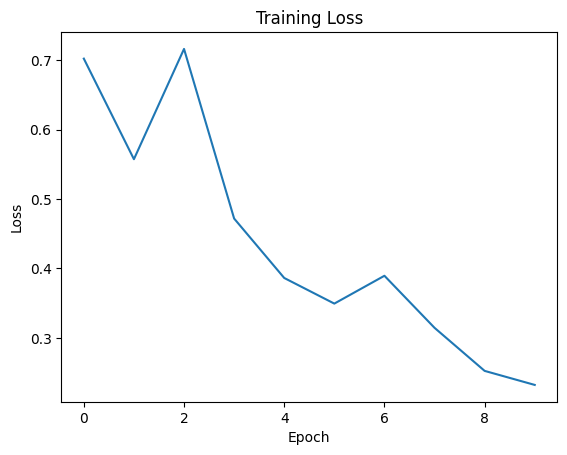

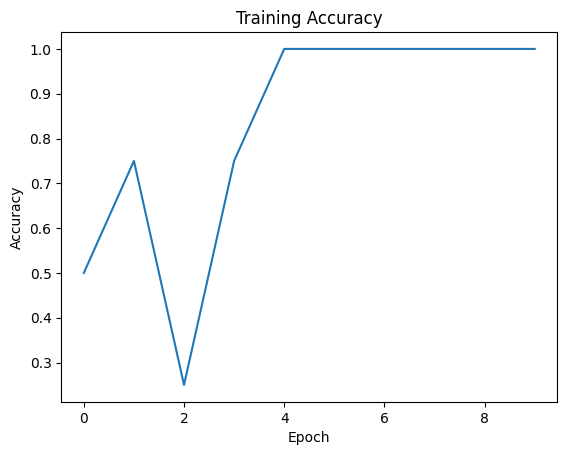

In [5]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# If you have additional metrics, you can plot them as well
# For example, if you have accuracy:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
